In [1]:
import os
print(os.getcwd())
os.chdir('/home/lxz/LIFT')
print(os.getcwd())

/home/lxz/LIFT/plot
/home/lxz/LIFT


In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from datasets import CIFAR100_IR100
from models import *
from trainer import load_clip_to_cpu
from torchattacks import PGD

from utils.config import _C as cfg
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np

os.chdir('/home/lxz/LIFT')

cfg.defrost()
cfg.merge_from_file('./configs/data/cifar100_ir100.yaml')
cfg.merge_from_file('./configs/model/clip_vit_b16.yaml')
cfg.adaptformer = True

if not torch.cuda.is_available():
    device = torch.device("cpu")
elif cfg.gpu is None:
    device = torch.device("cuda")
else:
    torch.cuda.set_device(cfg.gpu)
    device = torch.device("cuda:{}".format(cfg.gpu))

cfg.model_dir = './output/cifar100_ir100_clip_vit_b16_adaptformer_True_train_PGDAT_True'

/home/zyla/anaconda3/envs/LIFT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if cfg.backbone.startswith("CLIP"):
    mean = [0.48145466, 0.4578275, 0.40821073]
    std = [0.26862954, 0.26130258, 0.27577711]
else:
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]

transform_test = transforms.Compose([
    transforms.Resize(cfg.resolution * 8 // 7),
    transforms.CenterCrop(cfg.resolution),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = CIFAR100_IR100(root=cfg.root, train=True, transform=transform_test)
num_classes = train_dataset.num_classes
cls_num_list = train_dataset.cls_num_list
test_dataset = CIFAR100_IR100(root=cfg.root, train=False, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

clip_model = load_clip_to_cpu(cfg.backbone, cfg.prec)
model = PeftModelFromCLIP(cfg, clip_model, num_classes)
model.to(device)
tuner = model.tuner
head = model.head

load_path = os.path.join(cfg.model_dir, "checkpoint.pth.tar")
checkpoint = torch.load(load_path, map_location=device)
tuner_dict = checkpoint["tuner"]
head_dict = checkpoint["head"]
tuner.load_state_dict(tuner_dict)
head.load_state_dict(head_dict)

Files already downloaded and verified
Files already downloaded and verified
Adapter bottle dimension set to 4


<All keys matched successfully>

In [4]:
print(model)

PeftModelFromCLIP(
  (text_encoder): CLIP_Text(
    (token_embedding): Embedding(49408, 512)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=512, out_features=2048, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          )
          (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): 

In [ ]:
def reshape_transform(tensor, height=14, width=14):
    # tensor 形状为 [seq_len, batch_size, embedding_dim]
    # 排除类标记（序列长度维度的第一个标记）
    patch_tokens = tensor[1:, :, :]  # 形状为 [seq_len-1, batch_size, embedding_dim]
    # 转换格式为 [batch_size, seq_len-1, embedding_dim]
    patch_tokens = patch_tokens.permute(1, 0, 2)  # 形状为 [batch_size, seq_len-1, embedding_dim]
    # 重塑为空间网格 [batch_size, height, width, embedding_dim]
    result = patch_tokens.view(patch_tokens.size(0), height, width, patch_tokens.size(2))
    # 调整为 GradCAM 期望的格式 [batch_size, embedding_dim, height, width]
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [26]:
def visualize_image(model, original_image_tensor, target_layer, reshape_transform, save_path, label):
    model.eval()
    with torch.no_grad():
        output = model(original_image_tensor)
        predicted_class = output.max(1)[1].item()
    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
    grayscale_cam = cam(original_image_tensor)[0, :]
    # 修正 grayscale_cam 的格式
    grayscale_cam = grayscale_cam.squeeze()  # 移除多余的维度，例如 (1, height, width) -> (height, width)
    if grayscale_cam.ndim != 2:  # 检查是否为二维数组
        raise ValueError(f"grayscale_cam 必须是二维数组，当前形状为 {grayscale_cam.shape}")
    # 归一化到 0-1 范围
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)  # 避免除以零
    original_image = original_image_tensor[0].permute(1, 2, 0).cpu().numpy()
    original_image = (original_image * std + mean).clip(0, 1)
    plt.imshow(original_image)
    plt.axis('off')  # 关闭坐标轴
    plt.show()
    visualization = show_cam_on_image(original_image, grayscale_cam)
    plt.imsave(f"{save_path}/image_{predicted_class}_{label}.png", visualization)

  0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([196, 32, 768])
torch.Size([32, 196, 768])
torch.Size([196, 32, 768])
torch.Size([32, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


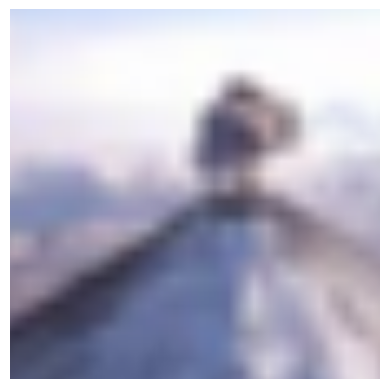

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


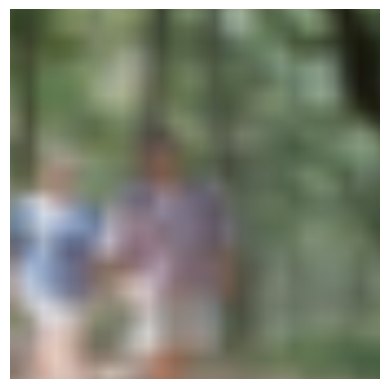

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


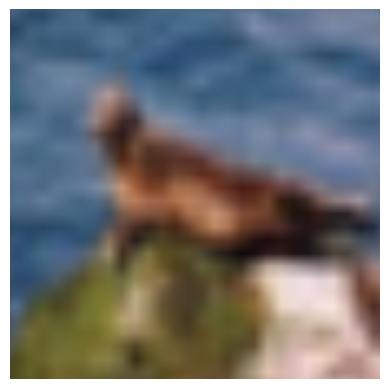

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


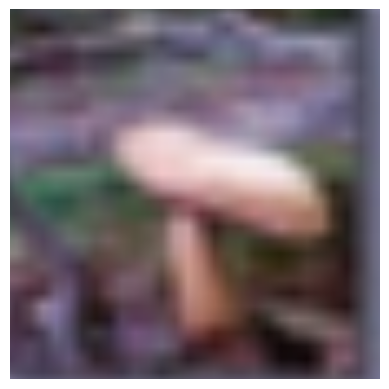

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


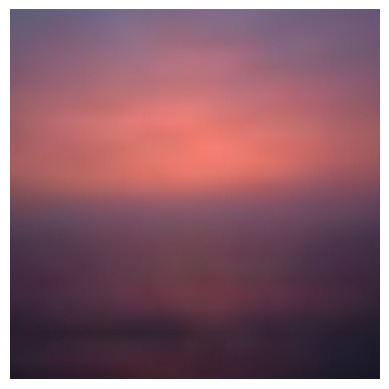

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


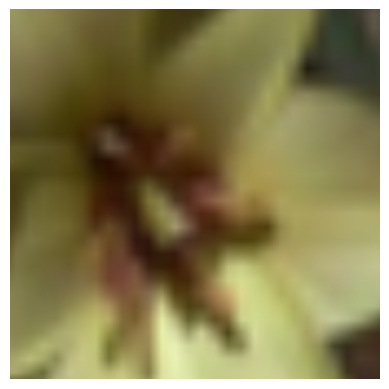

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


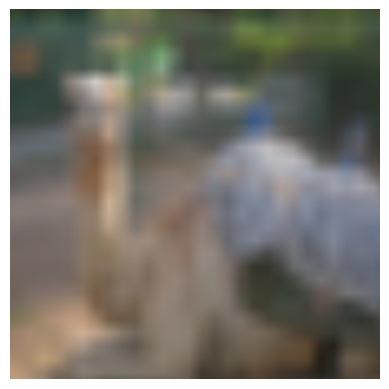

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


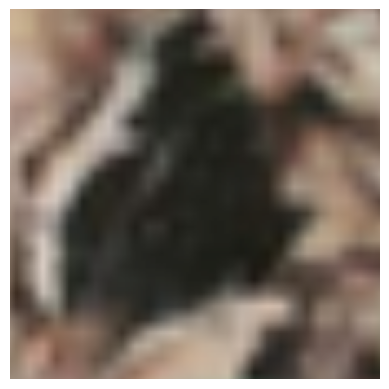

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


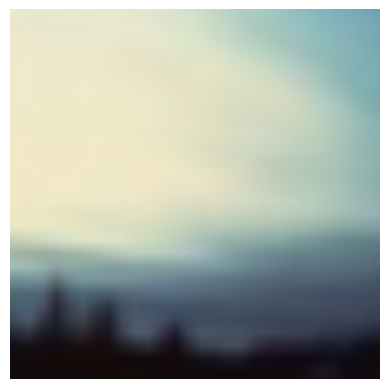

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


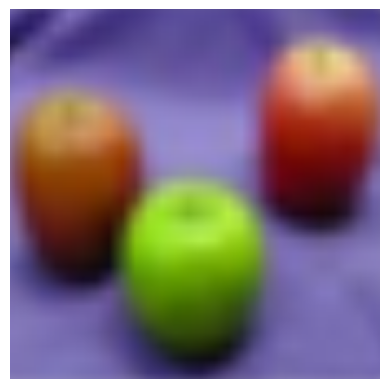

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


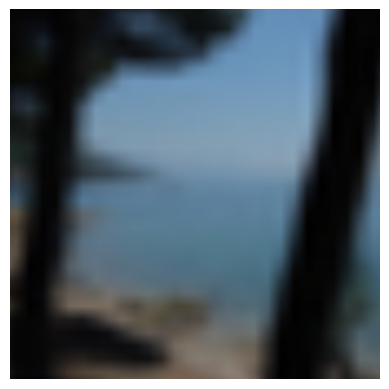

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


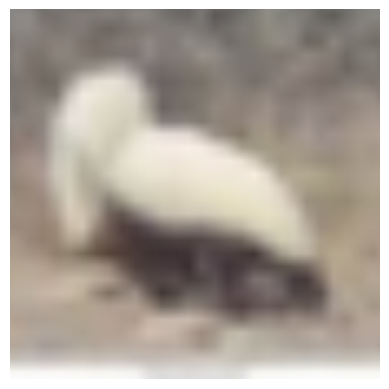

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


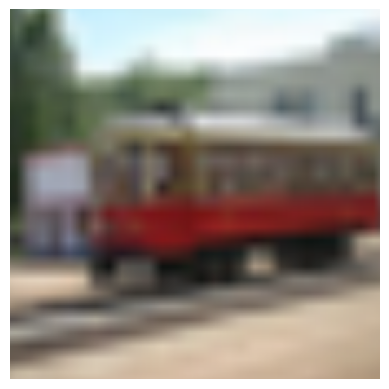

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


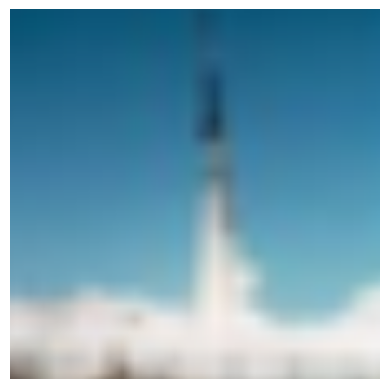

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


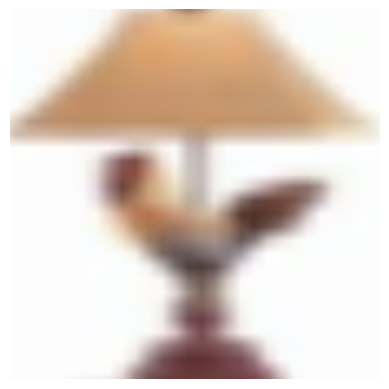

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


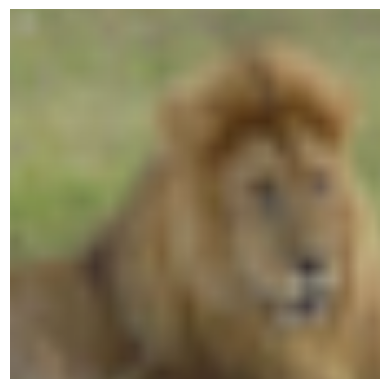

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


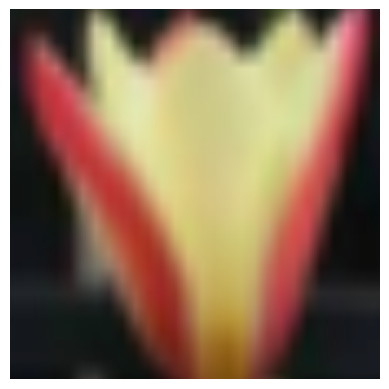

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


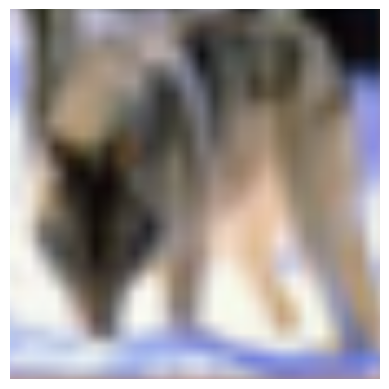

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


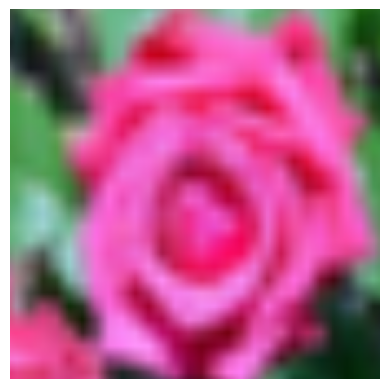

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


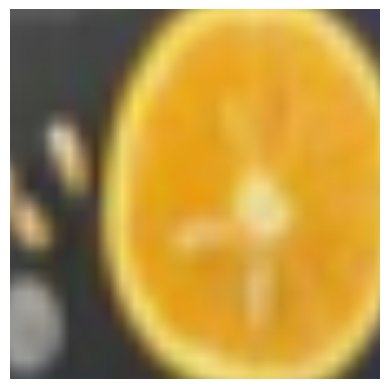

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


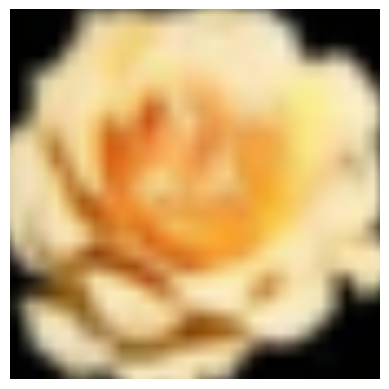

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


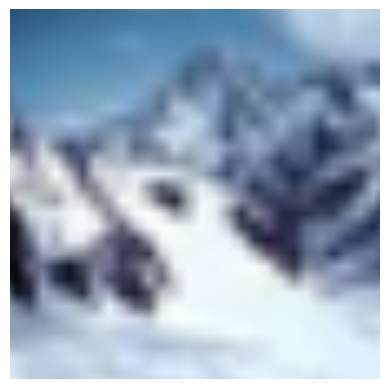

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


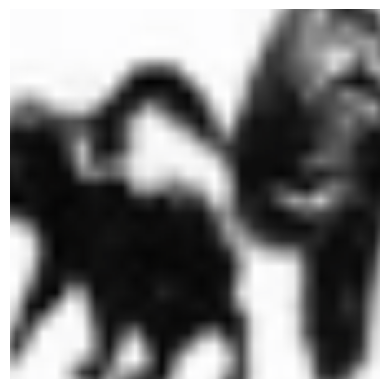

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


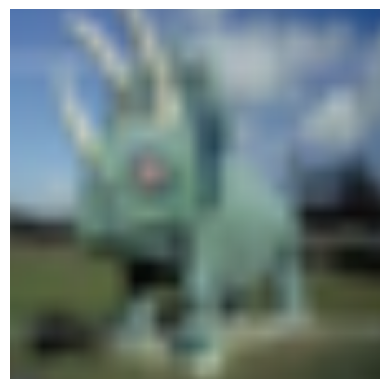

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


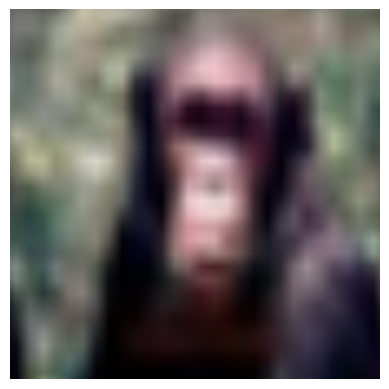

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


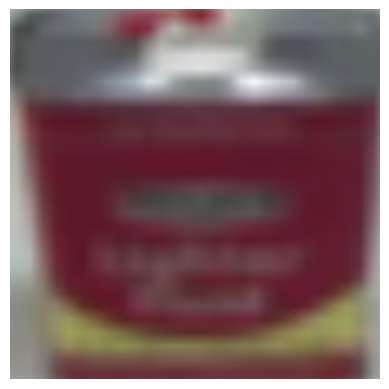

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


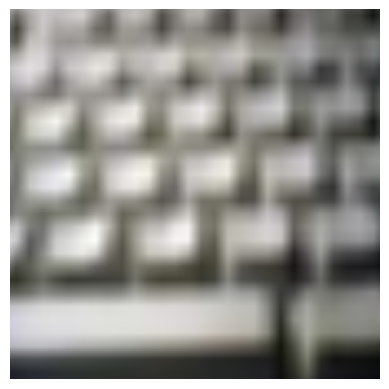

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


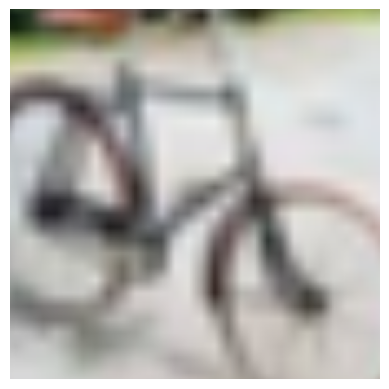

torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])
torch.Size([196, 1, 768])
torch.Size([1, 196, 768])


  0%|          | 0/313 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
epsilon = 8 / 255  # 攻击强度
alpha = 2 / 255  # 每步扰动量
num_iterations = 10  # 攻击迭代次数

model.eval()  # 切换到评估模式
class_names = test_dataset.classnames  # 类别名称
PGD_attack = PGD(model, epsilon, alpha, num_iterations)

for batch_idx, batch in enumerate(tqdm(test_loader, ascii=True)):
    images, labels = batch[0], batch[1]
    images, labels = images.to(device), labels.to(device)

    # 对抗样本生成
    #adversarial_images = PGD_attack(images, labels)
    # 预测
    with torch.no_grad():
        original_logits = model(images)
        original_preds = torch.argmax(original_logits, dim=1)
        #adversarial_logits = model(adversarial_images, attack_supervise="adv")
        #adversarial_preds = torch.argmax(adversarial_logits, dim=1)
    for img, label in zip(images, labels):
        visualize_image(model, img.unsqueeze(0), model.image_encoder.blocks[-2].ln_2, 
                       reshape_transform, "./output/Grad-CAM_output", label.item())

    